In [ ]:
# Check that imports for the rest of the file work.
import tensorflow.compat.v1 as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)  # Disable noisy outputs.

     |████████████████████████████████| 367 kB 24.9 MB/s 



In [ ]:
import tensorflow_datasets as tfds
import tensorflow.compat.v1 as tf

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist:3.*.*', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


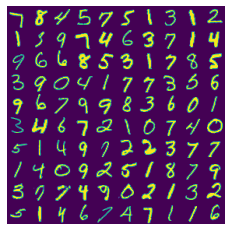

In [ ]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(iter(tfds.as_numpy(ds)))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

In [ ]:
def _dense(inputs, units, l2_weight):
  return tf.layers.dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _batch_norm(inputs, is_training):
  return tf.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

In [ ]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = _dense(net, 7 * 7 * 256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.nn.relu(net)
  
  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

In [ ]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = tf.layers.flatten(net)
  
  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)
  
  net = _dense(net, 1, weight_decay)

  return net

In [ ]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

In [ ]:
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:455: UserWarning: `layer.apply` is deprecated and will be removed i

Time since start: 9.54 min
Trained from step 0 to 500 in 0.87 steps / sec
Average discriminator output on Real: -12.44  Fake: -11.97
Inception Score: 5.80 / 8.35  Frechet Distance: 85.66


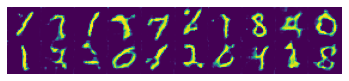

Time since start: 19.75 min
Trained from step 500 to 1000 in 0.88 steps / sec
Average discriminator output on Real: -15.52  Fake: -14.81
Inception Score: 6.66 / 8.35  Frechet Distance: 65.05


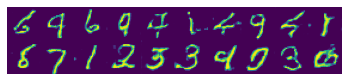

Time since start: 30.95 min
Trained from step 1000 to 1500 in 0.80 steps / sec
Average discriminator output on Real: -16.96  Fake: -17.10
Inception Score: 7.29 / 8.35  Frechet Distance: 58.54


Exception ignored in: <generator object Estimator.predict at 0x7f008c417dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


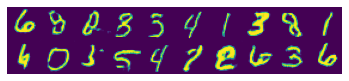

Time since start: 40.95 min
Trained from step 1500 to 2000 in 0.88 steps / sec
Average discriminator output on Real: -16.79  Fake: -17.75
Inception Score: 7.29 / 8.35  Frechet Distance: 54.70


Exception ignored in: <generator object Estimator.predict at 0x7f0089b05e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


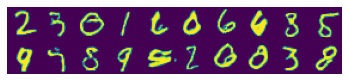

Time since start: 52.15 min
Trained from step 2000 to 2500 in 0.80 steps / sec
Average discriminator output on Real: -10.44  Fake: -12.64
Inception Score: 7.26 / 8.35  Frechet Distance: 64.70


Exception ignored in: <generator object Estimator.predict at 0x7f0089e12ad0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


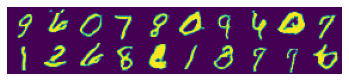

Time since start: 62.17 min
Trained from step 2500 to 3000 in 0.88 steps / sec
Average discriminator output on Real: -6.54  Fake: -8.31
Inception Score: 7.40 / 8.35  Frechet Distance: 57.59


Exception ignored in: <generator object Estimator.predict at 0x7f00889a7bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


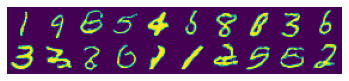

Time since start: 72.13 min
Trained from step 3000 to 3500 in 0.88 steps / sec
Average discriminator output on Real: 48.14  Fake: 43.27
Inception Score: 7.34 / 8.35  Frechet Distance: 59.51


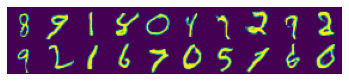

Exception ignored in: <generator object Estimator.predict at 0x7f0088c3b450>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


Time since start: 82.34 min
Trained from step 3500 to 4000 in 0.88 steps / sec
Average discriminator output on Real: 41.13  Fake: 31.36
Inception Score: 7.47 / 8.35  Frechet Distance: 53.62


Exception ignored in: <generator object Estimator.predict at 0x7f00874baf50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


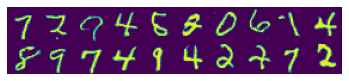

Time since start: 93.33 min
Trained from step 4000 to 4500 in 0.80 steps / sec
Average discriminator output on Real: -93.90  Fake: -83.30
Inception Score: 7.36 / 8.35  Frechet Distance: 61.65


Exception ignored in: <generator object Estimator.predict at 0x7f00871d6f50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


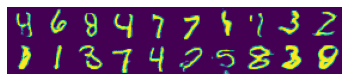

Time since start: 104.30 min
Trained from step 4500 to 5000 in 0.80 steps / sec
Average discriminator output on Real: 21.75  Fake: 5.60
Inception Score: 7.46 / 8.35  Frechet Distance: 60.95


Exception ignored in: <generator object Estimator.predict at 0x7f00860b80d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 647, in predict
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 5770, in get_controller
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 269, in pop
IndexError: pop from empty list


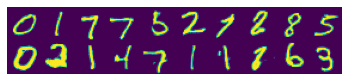

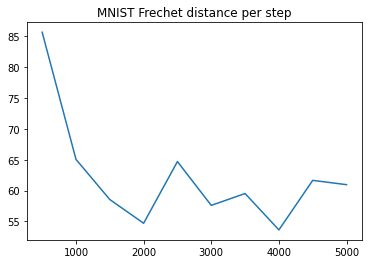

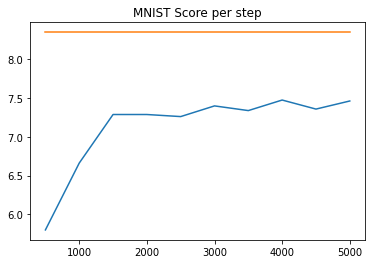

In [ ]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()